In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [72]:
# Load the dataset
file_path = 'Downloads/New folder/Airbnb_data.xlsx' 
df = pd.read_excel(file_path)

In [4]:
# Inspect the dataset
print("Dataset shape:", df.shape)
print("\nColumns and Data Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nFirst few rows:\n", df.head())

Dataset shape: (74111, 29)

Columns and Data Types:
 id                          int64
log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
description                object
first_review               object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate        float64
host_since                 object
instant_bookable           object
last_review                object
latitude                  float64
longitude                 float64
name                       object
neighbourhood              object
number_of_reviews           int64
review_scores_rating      float64
thumbnail_url              object
zipcode                    object
bedrooms                  flo

In [5]:
# Replace missing bathrooms, bedrooms, beds with median
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col] = df[col].fillna(df[col].median())

# Handle missing zipcodes (example: dropping if impact is minimal)
df = df.dropna(subset=['zipcode'])

# Convert log_price back to original price
df['price'] = np.exp(df['log_price'])

# Parse dates
date_cols = ['first_review', 'last_review', 'host_since']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], format='%d-%m-%Y', errors='coerce')

In [9]:
# Count the number of amenities
df['amenities_count'] = df['amenities'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

In [11]:
# Calculate host tenure in days
df['host_tenure'] = (datetime.now() - df['host_since']).dt.days

In [13]:
# Calculate the gap between first and last review
df['review_gap'] = (df['last_review'] - df['first_review']).dt.days

In [15]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
categorical_cols = ['property_type', 'room_type', 'cancellation_policy']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [17]:
from sklearn.preprocessing import MinMaxScaler

# Normalize selected numerical columns
scaler = MinMaxScaler()
numerical_cols = ['latitude', 'longitude', 'number_of_reviews']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [21]:
# Check cleaned data
print("\nCleaned Data Overview:\n", df.head())
print("\nSummary of Missing Values After Cleaning:\n", df.isnull().sum())

# Save the cleaned data
cleaned_file_path = 'Downloads/New folder/Airbnb_data.xlsx'
df.to_excel(cleaned_file_path, index=False)
print(f"Cleaned data saved to {cleaned_file_path}")


Cleaned Data Overview:
          id  log_price  property_type  room_type  \
0   6901257   5.010635              0          0   
1   6304928   5.129899              0          0   
2   7919400   4.976734              0          0   
3  13418779   6.620073             17          0   
4   3808709   4.744932              0          0   

                                           amenities  accommodates  bathrooms  \
0  {"Wireless Internet","Air conditioning",Kitche...             3        1.0   
1  {"Wireless Internet","Air conditioning",Kitche...             7        1.0   
2  {TV,"Cable TV","Wireless Internet","Air condit...             5        1.0   
3  {TV,"Cable TV",Internet,"Wireless Internet",Ki...             4        1.0   
4  {TV,Internet,"Wireless Internet","Air conditio...             2        1.0   

   bed_type  cancellation_policy  cleaning_fee  ... number_of_reviews  \
0  Real Bed                    2          True  ...          0.003306   
1  Real Bed                  

In [22]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df.drop(columns=['price', 'log_price', 'id', 'description', 'thumbnail_url', 'name', 'amenities'])
y = df['price']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print("Training Set:", X_train.shape)
print("Validation Set:", X_val.shape)
print("Testing Set:", X_test.shape)

Training Set: (51200, 26)
Validation Set: (10971, 26)
Testing Set: (10972, 26)


In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Separate numerical and categorical features
numerical_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'latitude', 'longitude', 'review_scores_rating', 'number_of_reviews']
categorical_features = ['property_type', 'room_type', 'cancellation_policy', 'bed_type']

# Preprocessor for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessor for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define pipeline for Linear Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Train Linear Regression Model
lr_pipeline.fit(X_train, y_train)

# Validate the model
y_pred_val = lr_pipeline.predict(X_val)

# Evaluate Linear Regression
print("Linear Regression Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_val)))
print("MAE:", mean_absolute_error(y_val, y_pred_val))
print("R²:", r2_score(y_val, y_pred_val))


Linear Regression Performance:
RMSE: 127.10079540030013
MAE: 69.05177296764114
R²: 0.40421871772751994


In [42]:
# Define pipeline for Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Train Random Forest Model
rf_pipeline.fit(X_train, y_train)

# Validate the model
y_pred_val = rf_pipeline.predict(X_val)

# Evaluate Random Forest
print("\nRandom Forest Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_val)))
print("MAE:", mean_absolute_error(y_val, y_pred_val))
print("R²:", r2_score(y_val, y_pred_val))

# Define pipeline for XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

# Train XGBoost Model
xgb_pipeline.fit(X_train, y_train)

# Validate the model
y_pred_val = xgb_pipeline.predict(X_val)

# Evaluate XGBoost
print("\nXGBoost Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_val)))
print("MAE:", mean_absolute_error(y_val, y_pred_val))
print("R²:", r2_score(y_val, y_pred_val))


Random Forest Performance:
RMSE: 110.07301855129136
MAE: 54.00862911387515
R²: 0.5531599715638447

XGBoost Performance:
RMSE: 108.44374300719014
MAE: 52.83793103424436
R²: 0.56629011928953


In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(y_true, y_pred, model_name):
    """Evaluate the model and print metrics."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    
    return rmse, mae, r2


In [62]:
# Evaluate Linear Regression
y_pred_test_lr = lr_pipeline.predict(X_test)
evaluate_model(y_test, y_pred_test_lr, "Linear Regression")

# Evaluate Random Forest
y_pred_test_rf = rf_pipeline.predict(X_test)
evaluate_model(y_test, y_pred_test_rf, "Random Forest")

# Evaluate XGBoost
y_pred_test_xgb = xgb_pipeline.predict(X_test)
evaluate_model(y_test, y_pred_test_xgb, "XGBoost")



Linear Regression Performance:
RMSE: 153.00
MAE: 84.63
R²: 0.19

Random Forest Performance:
RMSE: 115.70
MAE: 54.98
R²: 0.54

XGBoost Performance:
RMSE: 112.77
MAE: 54.25
R²: 0.56


(112.77233831713194, 54.25110624547605, 0.5624290153864812)

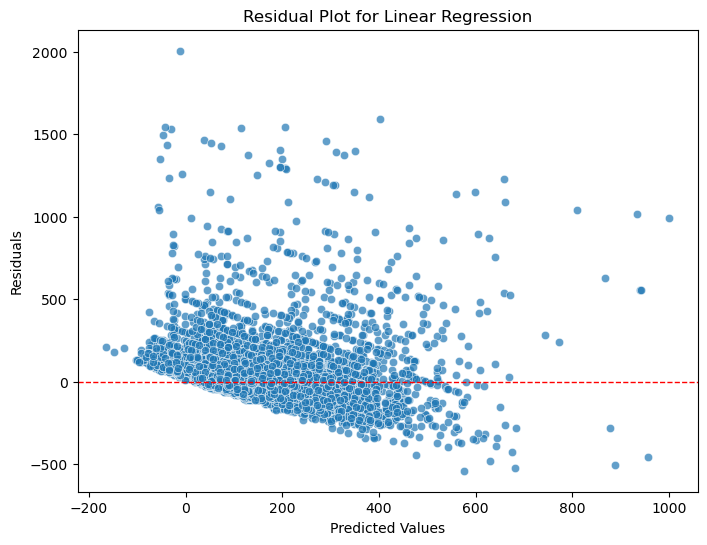

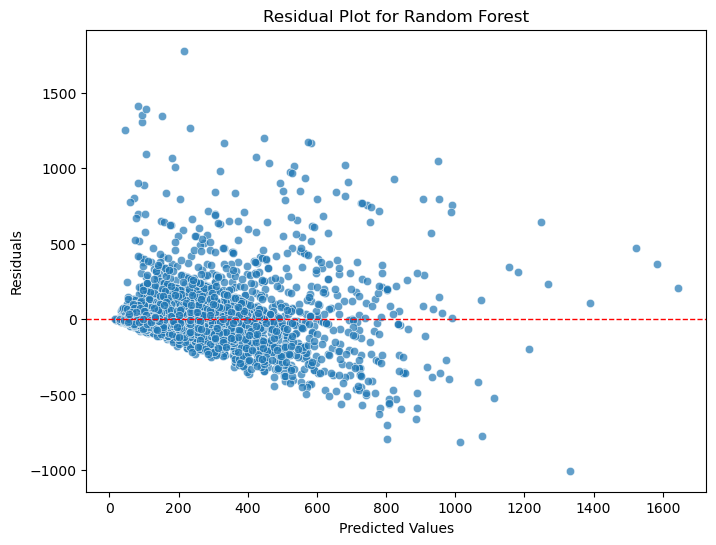

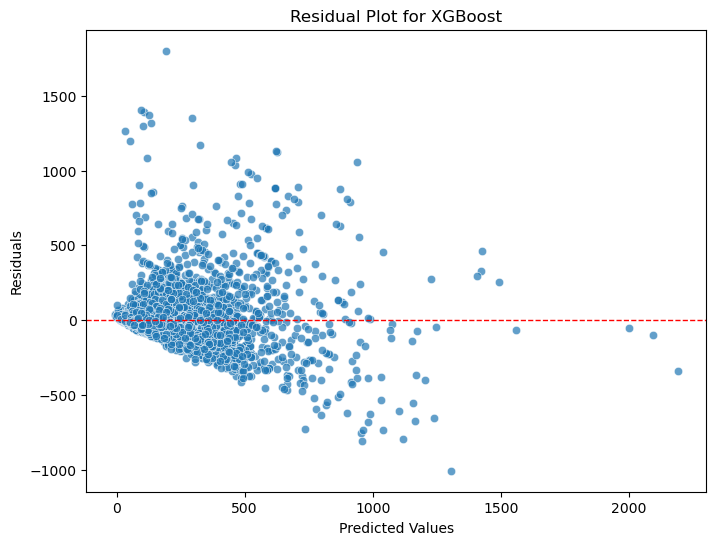

In [64]:
def plot_residuals(y_true, y_pred, model_name):
    """Plot residuals for the model."""
    residuals = y_true - y_pred
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title(f"Residual Plot for {model_name}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

# Residual plots for each model
plot_residuals(y_test, y_pred_test_lr, "Linear Regression")
plot_residuals(y_test, y_pred_test_rf, "Random Forest")
plot_residuals(y_test, y_pred_test_xgb, "XGBoost")



Model Performance Comparison:
               Model        RMSE        MAE        R²
0  Linear Regression  152.995867  84.627247  0.194616
1      Random Forest  115.695366  54.980531  0.539452
2            XGBoost  112.772338  54.251106  0.562429


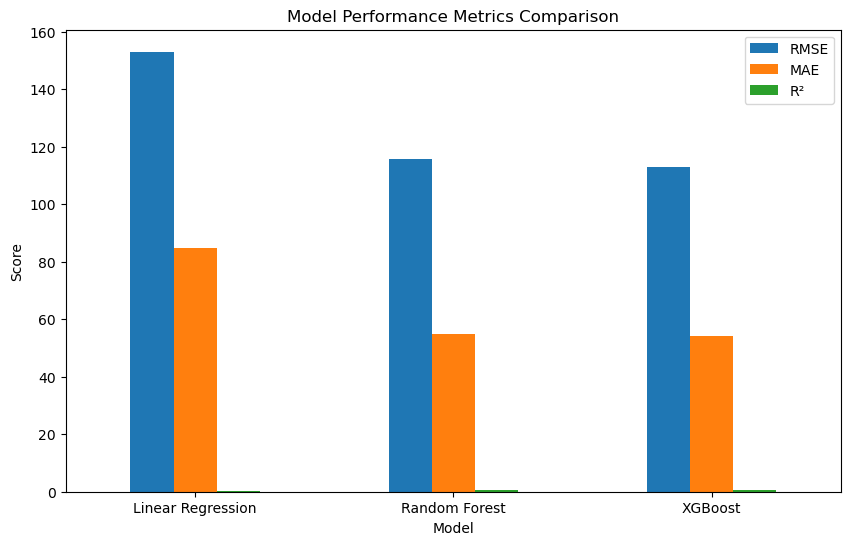

In [66]:
# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred_test_lr)),
             np.sqrt(mean_squared_error(y_test, y_pred_test_rf)),
             np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))],
    'MAE': [mean_absolute_error(y_test, y_pred_test_lr),
            mean_absolute_error(y_test, y_pred_test_rf),
            mean_absolute_error(y_test, y_pred_test_xgb)],
    'R²': [r2_score(y_test, y_pred_test_lr),
           r2_score(y_test, y_pred_test_rf),
           r2_score(y_test, y_pred_test_xgb)]
})

print("\nModel Performance Comparison:")
print(comparison_df)

# Visualize metric comparisons
comparison_df.set_index('Model').plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Model Performance Metrics Comparison")
plt.ylabel("Score")
plt.show()
